# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import io
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from rich import print
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    hamming_loss,
    jaccard_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from skmultilearn.dataset import load_dataset
from skmultilearn.problem_transform import BinaryRelevance

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

GOLDEN = (1 + 5**0.5) / 2

###### Function definitions


In [2]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(
        images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt"
    ).to(device=device, dtype=dtype)
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def get_prompt_groups(prompts):
    prompt_groups = {}
    prompt_groups.update({key: "A" for key in prompts.keys() if int(key) <= 10})
    prompt_groups.update(
        {key: "B" for key in prompts.keys() if ((int(key) >= 11) and (int(key) <= 20))}
    )
    prompt_groups.update(
        {key: "C" for key in prompts.keys() if ((int(key) >= 21) and (int(key) <= 30))}
    )

    return prompt_groups


def get_ypred(response, labels):
    return [label for label in labels if label in response]


def get_tps(series):
    tps = [x for x in series["y_pred"] if x in series["y_true"]]
    return tuple(tps)


def get_fps(series):
    fps = [x for x in series["y_pred"] if x not in series["y_true"]]
    return tuple(fps)


def get_tns(series, labels):
    tns = [x for x in labels if (x not in series["y_true"]) and (x not in series["y_pred"])]
    return tuple(tns)


def get_fns(series):
    fns = [x for x in series["y_true"] if x not in series["y_pred"]]
    return tuple(fns)


def get_sample_metrics(dataframe, labels):
    def combined_metrics(x):
        tps = get_tps(x)
        fps = get_fps(x)
        tns = get_tns(x, labels)
        fns = get_fns(x)
        return len(tps), len(fps), len(tns), len(fns)

    tps_len, fps_len, tns_len, fns_len = zip(*dataframe.apply(combined_metrics, axis=1))

    acc = (dataframe["y_pred"] == dataframe["y_true"]).astype(int)

    tps_len_series = pd.Series(tps_len, index=dataframe.index)
    fps_len_series = pd.Series(fps_len, index=dataframe.index)
    tns_len_series = pd.Series(tns_len, index=dataframe.index)
    fns_len_series = pd.Series(fns_len, index=dataframe.index)

    recall = tps_len_series / (tps_len_series + fns_len_series)
    prec = tps_len_series / (tps_len_series + fps_len_series)
    f1 = (2 * ((prec * recall) / (prec + recall))).fillna(0.0)

    return_df = pd.DataFrame(
        {
            "tps_len": tps_len_series,
            "fps_len": fps_len_series,
            "tns_len": tns_len_series,
            "fns_len": fns_len_series,
            "accuracy": acc,
            "recall": recall,
            "precision": prec,
            "f1": f1,
        }
    )

    return return_df


def compute_mlc_metrics_wide(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)

    # Multi-label averaging parameter options: "macro", "weighted", "micro", "samples", and None
    avg = None

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics_wide = pd.DataFrame()
    for zero_div in [0.0, 1.0, np.nan]:

        # zero-div param for jaccard score cannot be NAN
        if isinstance(zero_div, float) and np.isnan(zero_div):
            zero_div_j = 0.0
        else:
            zero_div_j = zero_div
        index_label_zero_div = index_label_zero_div_map[zero_div]

        jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
        precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
        recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
        f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)

        df_i = pd.DataFrame(
            np.vstack([jaccard, precision, recall, f1]),
            columns=mlb.classes_.tolist(),
            index=["jaccard", "precision", "recall", "f1"],
        )
        df_i.index.name = "metric"
        df_i["zerodiv_opt"] = index_label_zero_div
        df_i = df_i.reset_index()
        df_i = df_i[["zerodiv_opt", "metric"] + mlb.classes_.tolist()]

        metrics_wide = pd.concat([metrics_wide, df_i], ignore_index=True)

    metrics_wide = metrics_wide.sort_values("metric").reset_index(drop=True)

    return metrics_wide


def compute_mlc_metrics(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics = pd.DataFrame(
        columns=[
            "avg_opt",
            "zerodiv_opt",
            "accuracy",
            "hammingloss",
            "jaccard",
            "precision",
            "recall",
            "f1",
        ]
    )

    idx = 0
    for avg in ["macro", "weighted", "micro", "samples"]:
        for zero_div in [0.0, 1.0, np.nan]:
            # set avg param index label
            if avg:
                index_label_avg = avg
            else:
                index_label_avg = "none"

            # zero-div param for jaccard score cannot be NAN
            if isinstance(zero_div, float) and np.isnan(zero_div):
                zero_div_j = 0.0
            else:
                zero_div_j = zero_div
            index_label_zero_div = index_label_zero_div_map[zero_div]

            accuracy = accuracy_score(ytrue, ypred)
            # fraction of labels that are incorrectly predicted
            hammingloss = hamming_loss(ytrue, ypred)
            jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
            precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
            recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
            f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)

            metrics.loc[idx, :] = (
                index_label_avg,
                index_label_zero_div,
                accuracy,
                hammingloss,
                jaccard,
                precision,
                recall,
                f1,
            )
            idx += 1
    metrics[["accuracy", "hammingloss", "jaccard", "precision", "recall", "f1"]] = metrics.loc[
        :, ["accuracy", "hammingloss", "jaccard", "precision", "recall", "f1"]
    ].astype(float)
    return metrics

## NIH Chest X-ray dataset


###### Load dataset


In [88]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Rows: 112,120   Columns: 11

Number of patients: 30,805

###### Visualize data


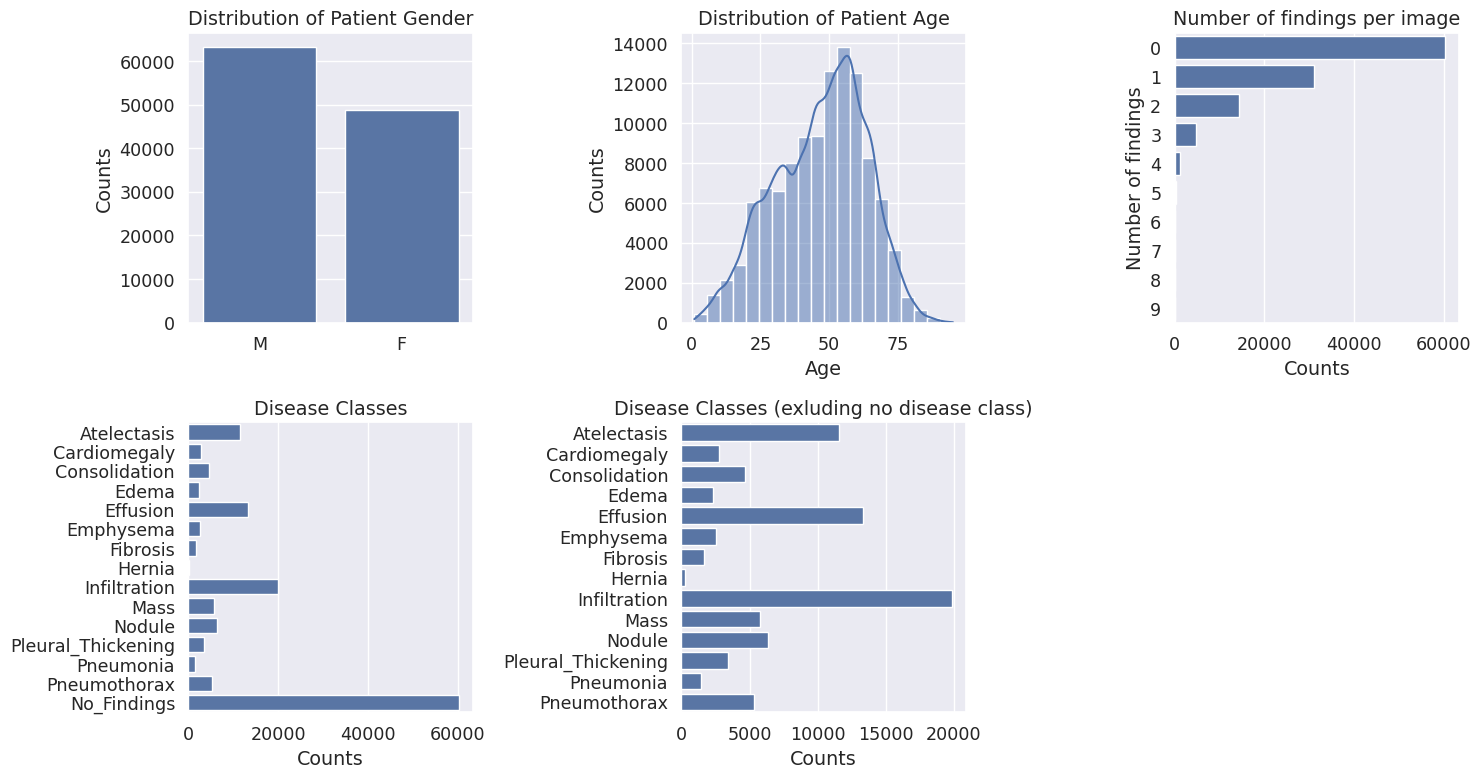

In [89]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [108]:
results.loc[results["finding_labels"].apply(lambda x: "Hernia" in x) & (results["n_labels"] == 1), :].drop_duplicates(subset=["image_index"])

,image_index,finding_labels,prompt_key,prompt_group,response,y_true,y_pred,n_labels,response_num_findings,tps_len,fps_len,tns_len,fns_len,accuracy,recall,precision,f1
40,00000003_000.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
50,00000003_001.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
60,00000003_002.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
80,00000003_004.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
90,00000003_005.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066583,00028948_002.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
1066612,00028948_005.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
1073064,00029188_001.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0
1078740,00029425_000.png,Hernia,1,A,No Finding,[Hernia],[No Finding],1,1,0,1,13,1,0,0.0,0.0,0.0


In [5]:
# data = data[column_names]

## Analyze prompts and responses


###### import results


In [6]:
# filelist = [x.as_posix() for x in Path("output").rglob("disease_classification_QA*.csv")]
filelist = [x.as_posix() for x in Path("output").rglob("CheXagent_results_on_NIH_CXR.csv.gz")]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(
        f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str
    )
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)

labels = (
    "Atelectasis", # relevant to IRF work
    "Cardiomegaly",
    "Consolidation", # relevant to IRF work
    "Edema",
    "Effusion", # relevant to IRF work
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration", # relevant to IRF work
    "Mass",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia", # relevant to IRF work
    "Pneumothorax",
    "No Finding", # relevant to IRF work
)
results["y_true"] = results["finding_labels"].str.split("|")
results["y_pred"] = results["response"].apply(lambda x: get_ypred(x, labels))
results["n_labels"] = results["y_true"].apply(len)
results["response_num_findings"] = results["y_pred"].apply(len)

mlb = MultiLabelBinarizer(classes=labels, sparse_output=False)
ytrue = mlb.fit_transform(results["y_true"])
ypred = mlb.fit_transform(results["y_pred"])

# make "prompt_key" categorical
prompt_file_list = Path("data").glob("prompts*")
prompts = {}
for prompt_file in prompt_file_list:
    with open(prompt_file.as_posix(), "r") as json_file:
        data = json.load(json_file)
        prompts.update(data)

prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]

results["prompt_key"] = pd.Categorical(
    results["prompt_key"], ordered=True, categories=prompt_key_order
)

prompt_groups = get_prompt_groups(prompts)
results["prompt_group"] = results["prompt_key"].map(prompt_groups)
cols = ["image_index", "finding_labels", "prompt_key", "prompt_group", "response", "y_true", "y_pred", "n_labels", "response_num_findings"]  # fmt: skip # nopep8
results = results[cols]
cols = ["tps_len", "fps_len", "tns_len", "fns_len", "accuracy", "recall", "precision", "f1"]  # fmt: skip # nopep8
results[cols] = get_sample_metrics(results, labels)

# remove outlier case
# results = results.loc[results["response_num_findings"] != 0, :]

results = results.sort_values(["image_index", "prompt_key"], ignore_index=True)

disp_df(results)

,image_index,finding_labels,prompt_key,prompt_group,response,y_true,y_pred,n_labels,response_num_findings,tps_len,fps_len,tns_len,fns_len,accuracy,recall,precision,f1
0,00000001_000.png,Cardiomegaly,1,A,No Finding,[Cardiomegaly],[No Finding],1,1,0,1,13,1,0,0.0,0.00,0.0
1,00000001_000.png,Cardiomegaly,2,A,"A) 'Atelectasis', B) 'Cardiomegaly', D) 'Edema...",[Cardiomegaly],"[Atelectasis, Cardiomegaly, Edema, Effusion]",1,4,1,3,11,0,0,1.0,0.25,0.4
2,00000001_000.png,Cardiomegaly,3,A,"A) 'Atelectasis', B) 'Cardiomegaly', D) 'Edema...",[Cardiomegaly],"[Atelectasis, Cardiomegaly, Edema, Effusion]",1,4,1,3,11,0,0,1.0,0.25,0.4
3,00000001_000.png,Cardiomegaly,4,A,B) 'Cardiomegaly',[Cardiomegaly],[Cardiomegaly],1,1,1,0,14,0,1,1.0,1.00,1.0
4,00000001_000.png,Cardiomegaly,5,A,"A) 'Atelectasis', B) 'Cardiomegaly', D) 'Edema...",[Cardiomegaly],"[Atelectasis, Cardiomegaly, Edema, Effusion]",1,4,1,3,11,0,0,1.0,0.25,0.4


nRows: 1,114,710        nColumns: 17

In [7]:
dv = results.sample(1000)

#### Evaluate MLC task of the different prompts

[Comprehensive comparative study of multi-label classification methods](https://doi.org/10.1016/j.eswa.2022.117215)

4.5 Statistical evaluation if performance of the methods are statisitically significant:

- corrected Friedman test (non-parametric multiple hypothesis test)
- post-hoc Nemenyi test


In [9]:
df1 = results[results["prompt_group"] == "A"].copy()
df2 = results[results["prompt_group"] == "B"].copy()
df3 = results[results["prompt_group"] == "C"].copy()

n_labels
1    913240
Name: count, dtype: int64

response_num_findings
1     734704
15     56059
2      46658
3      21319
13     17940
6       8062
4       6714
7       4948
5       4432
11      2871
9       2759
12      2337
14      2178
8       2048
10       208
0          3
Name: count, dtype: int64

tps_len
0    517626
1    395614
Name: count, dtype: int64

fps_len
1     440867
0     297466
14     56110
2      48502
3      17702
12     17304
6       7388
4       5907
5       5523
7       4220
13      2850
10      2697
8       2602
11      2437
9       1665
Name: count, dtype: int64

tns_len
13    440867
14    297466
0      56110
12     48502
11     17702
2      17304
8       7388
10      5907
9       5523
7       4220
1       2850
4       2697
6       2602
3       2437
5       1665
Name: count, dtype: int64

fns_len
1    517626
0    395614
Name: count, dtype: int64

accuracy
0    615777
1    297463
Name: count, dtype: int64

recall
0.0    517626
1.0    395614
Name: count, dtype: int64

precision
0.000000    517623
1.000000    297463
0.066667     56059
0.076923     17217
0.333333      5470
0.500000      3626
0.090909      2684
0.083333      2250
0.166667      2137
0.071429      2127
0.250000      1853
0.142857      1463
0.111111      1289
0.200000      1046
0.125000       735
0.100000       195
Name: count, dtype: int64

f1
0.000000    517626
1.000000    297463
0.125000     56059
0.142857     17217
0.500000      5470
0.666667      3626
0.166667      2684
0.153846      2250
0.285714      2137
0.133333      2127
0.400000      1853
0.250000      1463
0.200000      1289
0.333333      1046
0.222222       735
0.181818       195
Name: count, dtype: int64

##### Reproduce `sklearn` metrics

In [ ]:
# subset results
df_res = results[results["prompt_key"] == "1"].copy()

disp_df(df_res)

In [ ]:
# Isolate one particular label and analyze one binary case
true_0, pred_0 = ytrue[df_res.index][:, 0], ypred[df_res.index][:, 0]
temp = pd.DataFrame({"true": true_0, "pred": pred_0})

temp["true_pos"] = 0.0
temp.loc[(temp["true"] == 1) & (temp["pred"] == 1), "true_pos"] = 1

temp["true_neg"] = 0.0
temp.loc[(temp["true"] == 0) & (temp["pred"] == 0), "true_neg"] = 1

temp["false_pos"] = 0.0
temp.loc[(temp["true"] == 0) & (temp["pred"] == 1), "false_pos"] = 1

temp["false_neg"] = 0.0
temp.loc[(temp["true"] == 1) & (temp["pred"] == 0), "false_neg"] = 1

disp_df(temp)

val_binary = recall_score(true_0, pred_0, average="binary", zero_division=0.0)
val_micro = recall_score(true_0, pred_0, average="micro", zero_division=0.0)
val_macro = recall_score(true_0, pred_0, average="macro", zero_division=0.0)
print(f"recall(avg='binary'): {val_binary}")
print(f"recall(avg='micro' or 'weighted'): {val_micro}")
print(f"recall(avg='macro'): {val_macro}")

# this matches average = "binary"
val = temp["true_pos"].sum() / (temp["true_pos"].sum() + temp["false_neg"].sum())
print(f"replicate metric for avg='binary': {val}")

# this matches average = "micro" or "weighted"
val = (temp["true_pos"].sum() + temp["true_neg"].sum()) / temp.shape[0]
print(f"replicate metric for avg='micro' or 'weighted': {val}")

# this matches average = "macro"
val = recall_score(true_0, pred_0, average=None, zero_division=0.0).mean()
print(f"replicate metric for avg='macro': {val}")

In [ ]:
metrics_wide = compute_mlc_metrics_wide(df_res, labels)
metrics = compute_mlc_metrics(df_res, labels)
display(metrics_wide)
display(metrics)

In [ ]:
metrics_wide.drop_duplicates(subset=metrics_wide.select_dtypes(include="number").columns)

In [ ]:
metrics.drop_duplicates(subset=metrics.select_dtypes(include="number").columns)

In [ ]:
metrics.set_index(["avg_opt", "zerodiv_opt"]).iloc[:, -4:].rank(ascending=False)

In [ ]:
metrics.set_index(["avg_opt", "zerodiv_opt"]).iloc[:, -4:].rank(ascending=False).mean(
    axis=1
).sort_values()

#### Plots


##### Confusion matrix


In [14]:
prompt_keys = results["prompt_key"].unique()

df_agg_wide = pd.DataFrame()
df_agg = pd.DataFrame()
for prompt_key in prompt_keys:
    df_input = results[results["prompt_key"] == prompt_key].copy()

    metrics_wide_i = compute_mlc_metrics_wide(df_input, labels)
    metrics_wide_i["prompt_key"] = prompt_key
    df_agg_wide = pd.concat([df_agg_wide, metrics_wide_i], ignore_index=True)

    metrics_i = compute_mlc_metrics(df_input, labels)
    metrics_i["prompt_key"] = prompt_key
    df_agg = pd.concat([df_agg, metrics_i], ignore_index=True)

df_agg["prompt_group"] = df_agg["prompt_key"].map(prompt_groups)
df_agg_wide["prompt_group"] = df_agg_wide["prompt_key"].map(prompt_groups)

display(df_agg_wide)
display(df_agg)

,zerodiv_opt,metric,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding,prompt_key,prompt_group
0,0,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.000000,0.000000,0.000000,0.016751,0.032200,0.002199,0.000000,0.015000,0.006352,0.796219,1,A
1,1,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.000000,0.000000,0.000000,0.016751,0.032200,0.002199,0.000000,0.015000,0.006352,0.796219,1,A
2,nan,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.000000,0.000000,0.000000,0.016751,0.032200,0.002199,0.000000,0.015000,0.006352,0.796219,1,A
3,0,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.000000,0.000000,0.000000,0.008446,0.016364,0.001101,0.000000,0.007557,0.003186,0.661432,1,A
4,1,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.000000,0.000000,0.000000,0.008446,0.016364,0.001101,0.000000,0.007557,0.003186,0.661432,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,precision,0.730539,0.769231,0.389535,0.406433,0.863572,0.471545,0.251656,1.000000,0.775701,1.000000,1.000000,0.247649,0.162121,0.788462,1.000000,30,C
344,nan,precision,0.730539,0.769231,0.389535,0.406433,0.863572,0.471545,0.251656,1.000000,0.775701,1.000000,1.000000,0.247649,0.162121,0.788462,NaN,30,C
345,0,recall,0.114161,0.122283,0.040954,0.348808,0.448904,0.078804,0.104110,0.022727,0.041212,0.002465,0.000724,0.351111,0.189381,0.094761,0.000000,30,C
346,1,recall,0.114161,0.122283,0.040954,0.348808,0.448904,0.078804,0.104110,0.022727,0.041212,0.002465,0.000724,0.351111,0.189381,0.094761,1.000000,30,C


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,recall,f1,prompt_key,prompt_group
0,macro,0,0.654253,0.047746,0.056589,0.175624,0.084318,0.077175,1,A
1,macro,1,0.654253,0.047746,0.056589,0.242290,0.084318,0.077175,1,A
2,macro,nan,0.654253,0.047746,0.056589,0.188168,0.084318,0.077175,1,A
3,weighted,0,0.654253,0.047746,0.442697,0.507709,0.660144,0.536900,1,A
4,weighted,1,0.654253,0.047746,0.442697,0.508913,0.660144,0.536900,1,A
...,...,...,...,...,...,...,...,...,...,...
343,micro,1,0.000000,0.216302,0.143119,0.541911,0.162817,0.250400,30,C
344,micro,nan,0.000000,0.216302,0.143119,0.541911,0.162817,0.250400,30,C
345,samples,0,0.000000,0.216302,0.165318,0.541911,0.165318,0.252188,30,C
346,samples,1,0.000000,0.216302,0.165318,0.541911,0.165318,0.252188,30,C


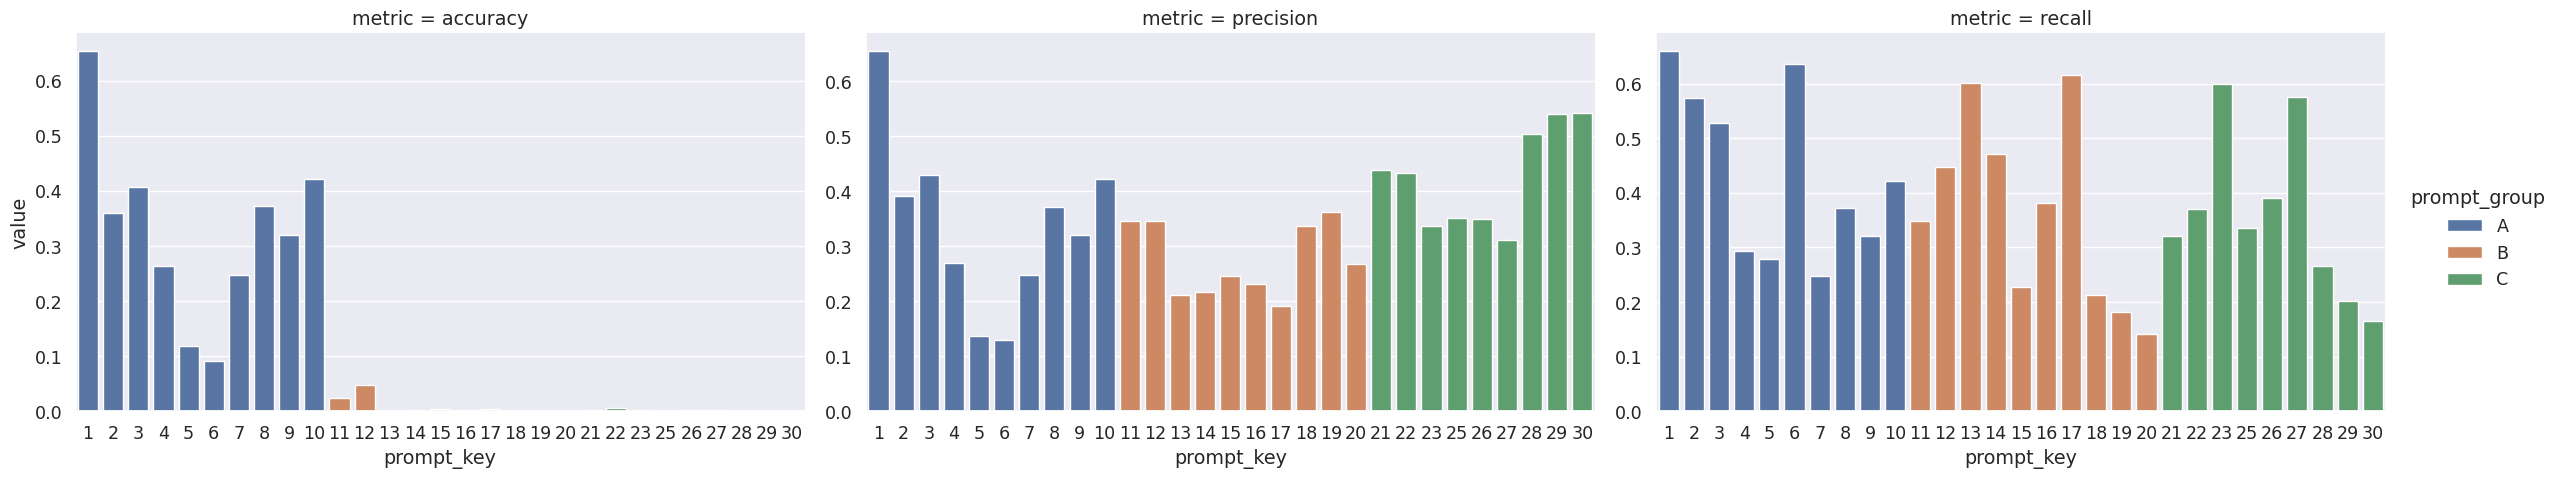

In [86]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg.loc[df_agg["zerodiv_opt"] == "nan"]
    .loc[df_agg["avg_opt"] == "samples"]
    .drop(columns=["avg_opt", "zerodiv_opt"])
    .melt(id_vars=["prompt_key", "prompt_group"], var_name="metric")
    .pipe(lambda x: x[x["metric"].isin(["accuracy", "precision", "recall"])])
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["metric", "prompt_key"], ignore_index=True)

g = sns.catplot(
    data=plotdf,
    x="prompt_key",
    y="value",
    hue="prompt_group",
    col="metric",
    col_wrap=3,
    kind="bar",
    sharey=False,
    aspect=GOLDEN,
)

In [87]:
# # re-create plot from results dataframe
# sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

# plotdf = results.melt(
#     id_vars=["image_index", "prompt_key", "prompt_group", "y_true", "y_pred"],
#     value_vars=["accuracy", "recall", "precision"],
#     var_name="metric",
# )
# plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
# # plotdf = plotdf.sort_values(["metric", "prompt_key"], ignore_index=True)

# g = sns.catplot(
#     data=plotdf,
#     x="prompt_key",
#     y="value",
#     hue="prompt_group",
#     col="metric",
#     col_wrap=1,
#     col_order=["accuracy", "precision", "recall"],
#     kind="bar",
#     sharey=False,
#     aspect=GOLDEN,
# )

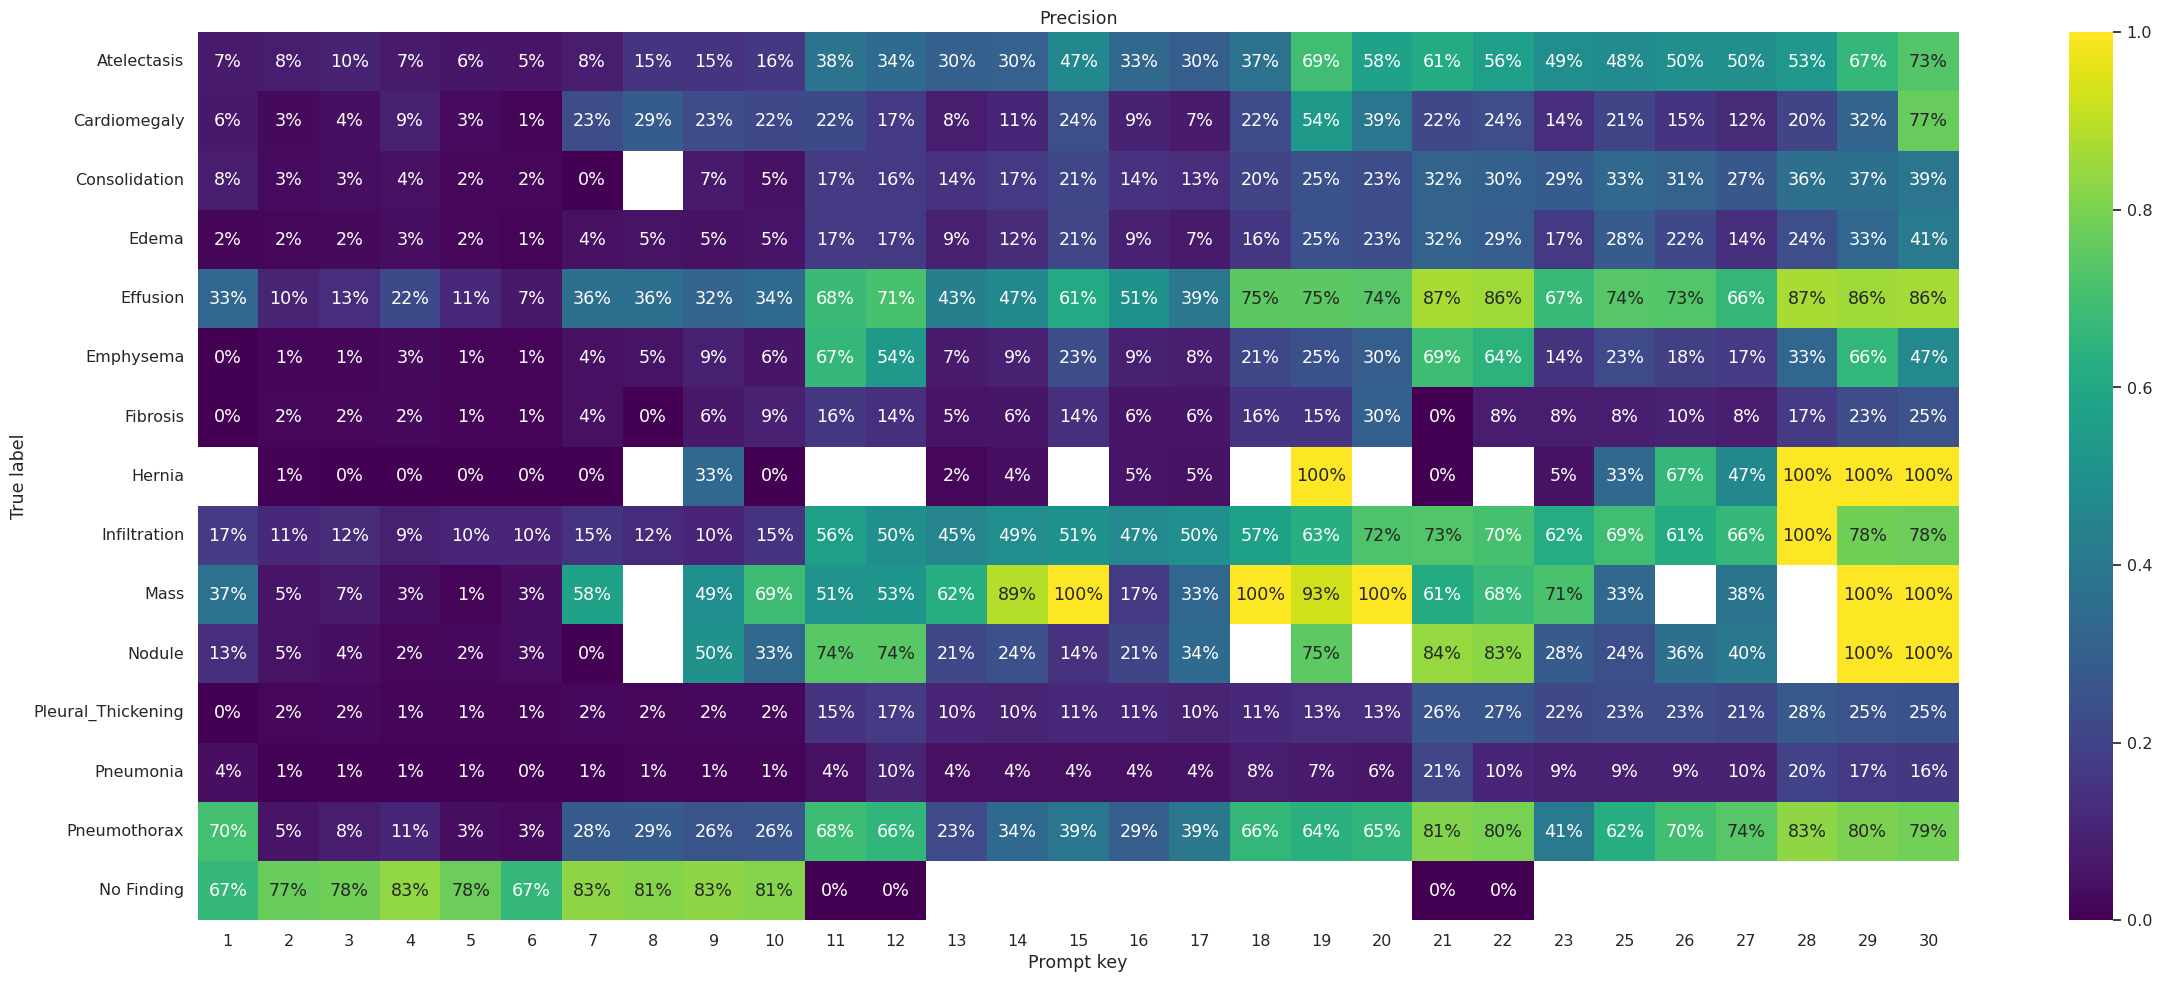

In [109]:
# TODO: give annotation of how many images with that particular finding label, eg Hernia (227)
sns.set_theme(context="notebook", style="white", font_scale=1.05)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "precision"]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group"])
    .set_index("prompt_key")
    .T
    # .melt(id_vars=["metric", "prompt_key", "prompt_group"], var_name="class")
)

plt.figure(figsize=(GOLDEN * 15, 10))
ax = sns.heatmap(plotdf, annot=True, fmt=".0%", cmap="viridis")
ax.set(
    title="Precision",
    xlabel="Prompt key",
    ylabel="True label",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

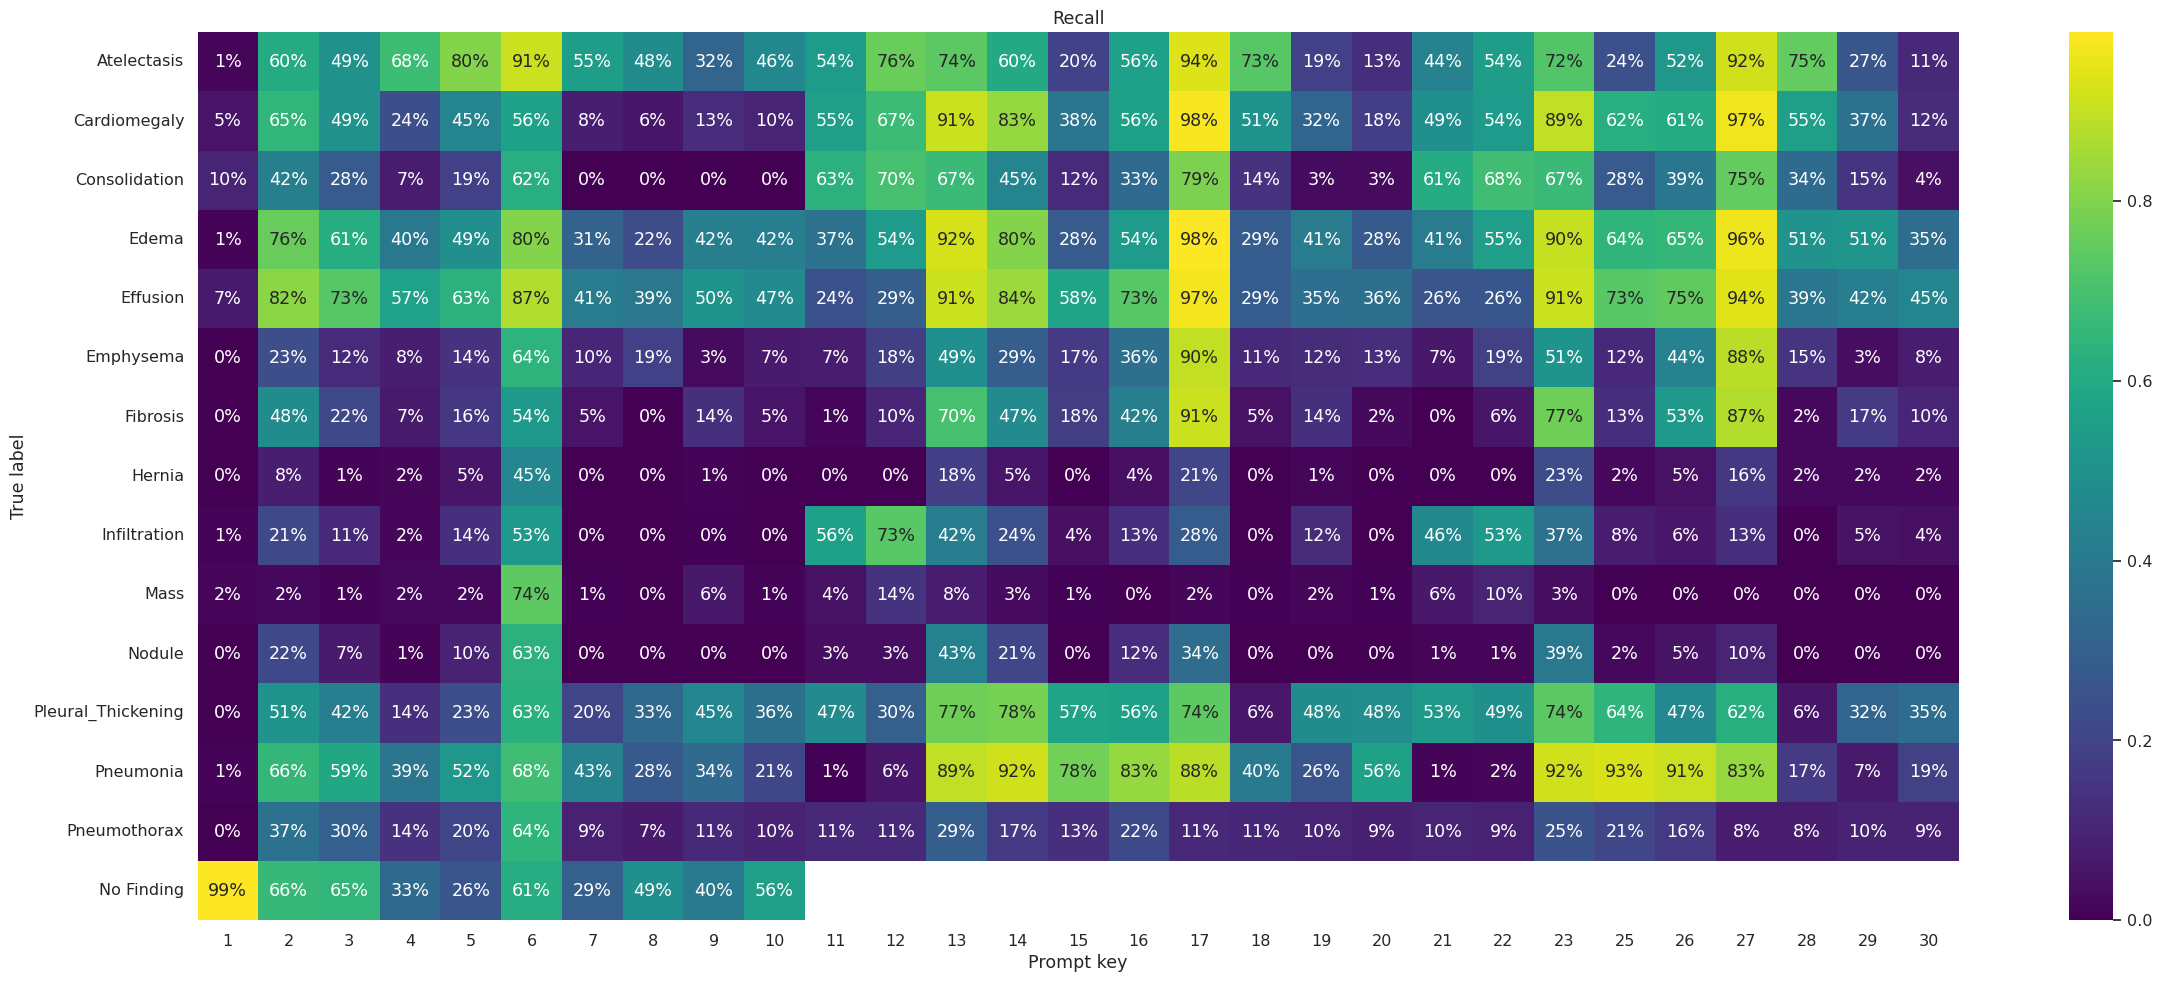

In [110]:
sns.set_theme(context="notebook", style="white", font_scale=1.05)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "recall"]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group"])
    .set_index("prompt_key")
    .T
    # .melt(id_vars=["metric", "prompt_key", "prompt_group"], var_name="class")
)

plt.figure(figsize=(GOLDEN * 15, 10))
ax = sns.heatmap(plotdf, annot=True, fmt=".0%", cmap="viridis")
ax.set(
    title="Recall",
    xlabel="Prompt key",
    ylabel="True label",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "precision"]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(1, 11))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(11, 21))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(21, 31))]
    .drop(columns=["zerodiv_opt"])
    .melt(id_vars=["metric", "prompt_key"], var_name="class")
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["prompt_key", "class", "metric"], ignore_index=True)
g = sns.catplot(
    data=plotdf,
    x="prompt_key",
    y="value",
    col="class",
    col_wrap=3,
    kind="bar",
    sharey=True,
    aspect=1.602,
)

In [ ]:
# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(ytrue, ypred)


# Function to plot confusion matrices for each class
def plot_multilabel_confusion_matrix(mcm, classes):
    fig, axes = plt.subplots(
        nrows=int(len(classes) / 2) + len(classes) % 2,
        ncols=2,
        figsize=(10, 4 * int(len(classes) / 2)),
    )
    for i, (cm, class_name) in enumerate(zip(mcm, classes)):
        ax = axes.flatten()[i]
        sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Class: {class_name}")
        ax.xaxis.set_ticklabels(["Negative", "Positive"])
        ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.tight_layout()
    plt.show()


# Plotting the confusion matrices
plot_multilabel_confusion_matrix(mcm, mlb.classes_)

In [ ]:
conf_matrices = {label: {"TP": 0, "FP": 0, "TN": 0, "FN": 0} for label in labels}


def update_conf_matrix(row, label):
    if label in row["true_positives"]:
        conf_matrices[label]["TP"] += 1
    if label in row["false_positives"]:
        conf_matrices[label]["FP"] += 1
    if label in row["true_negatives"]:
        conf_matrices[label]["TN"] += 1
    if label in row["false_negatives"]:
        conf_matrices[label]["FN"] += 1


for label in labels:
    results.apply(lambda row: update_conf_matrix(row, label), axis=1)


conf_matrices

In [ ]:
sns.set_theme(style="white")

for label, matrix in conf_matrices.items():
    cm = np.array([[matrix["TP"], matrix["FP"]], [matrix["FN"], matrix["TN"]]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### Histogram on `response_num_findings`


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(ytrue, ypred, average="weighted")

In [ ]:
results.head().apply(lambda x: 1 if len(get_tps(x)) > 0 else 0, axis=1)

In [ ]:
results.head().apply(lambda x: 1 if len(get_tps(x)) > 0 else 0, axis=1)

In [ ]:
get_sample_metrics(results, labels)

In [ ]:
plotdf = results.copy()
col_list = [
    "tps_len",
    "fps_len",
    "tns_len",
    "fns_len",
    "accuracy",
    "recall",
    "precision",
    "specificity",
    "f1",
]
plotdf[col_list] = get_sample_metrics(plotdf, labels)

plotdf

In [ ]:
mlb.transform(dv.y_true)

In [ ]:
mlb.transform(dv.y_pred)

In [ ]:
# dv.loc[dv.y_true == ("",), "y_true"] = ()

In [ ]:
np.reshape(labels, (1, len(labels)))

In [ ]:
def prfs(series, mlb):
    labels = mlb.classes_

    # y_pred = ("",) if series["y_pred"] == () else series["y_pred"]

    y_pred = np.reshape(series["y_pred"], (1, len(series["y_pred"])))
    y_true = np.reshape(series["y_true"], (1, len(series["y_true"])))

    y_pred = mlb.transform(y_pred).flatten()
    y_true = mlb.transform(y_true).flatten()

    return precision_recall_fscore_support(y_true, y_pred)

In [ ]:
a = ([1.0], [1.0], [1.0], [14])
np.ravel(a)

In [ ]:
mlb.transform(dv["y_true"])

In [ ]:
mlb.transform(dv["y_pred"])

In [ ]:
transformed_array = np.hstack((mlb.transform(dv["y_true"]), mlb.transform(dv["y_pred"]))).reshape(
    (dv.shape[0], 2, len(mlb.classes_))
)
display(transformed_array)

In [ ]:
x = [
    np.array(
        precision_recall_fscore_support(yt, yp, average="samples", zero_division=0.0)
    ).flatten()
    for yt, yp in transformed_array
]

In [ ]:
x

In [ ]:
pd.DataFrame(np.vstack(x))

In [ ]:
[len(a) for a in x]

In [ ]:
dv.apply(
    lambda x: prfs(x, mlb),
    axis=1,
)

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)
plotdf = results.copy()
g = sns.displot(
    data=plotdf,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


In [ ]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(
    title="Number of findings in response by prompt",
    xlabel="Prompt Key",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multi-finding imags


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.relplot(
    data=results,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()